In [1]:
import rps.robotarium as robotarium
from rps.utilities.transformations import *
from rps.utilities.barrier_certificates import *
from rps.utilities.misc import *
from rps.utilities.controllers import *

import numpy as np
import time


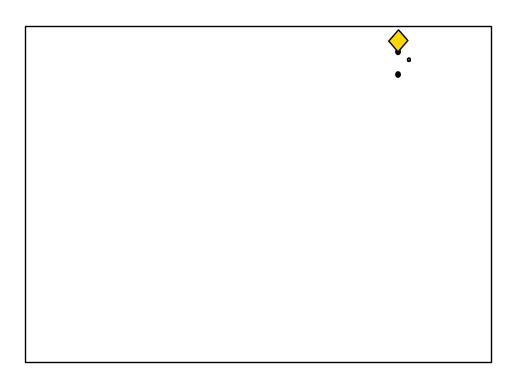

<Figure size 640x480 with 0 Axes>

In [2]:
X_plot = [] #Position log for plotting

# Instantiate Robotarium object
N = 1 #One robot
init_conditions = np.array(np.mat('1; 0.8; 0')) #Initial robot pose Perchè è tridimensionale invece che planare? 
#Perchè oltre x,y diamo la posa, che nel nostro caso supporremo zero. L'angolo theta è  quello perpendicolare all'asse delle ruote. 
#Questo si chiama poszione della mano. Nel nostro caso inizia dalla posizione 1, 0.8 con orientazione di 0 radianti. 

r = robotarium.Robotarium(number_of_robots=N, show_figure=True, initial_conditions=init_conditions, sim_in_real_time=False) #Launch the Robotarium
#i parametri sono il numero di robot, la figura da mostrare, le condiizoni iniziali e la simulazione in tempo reale. Quando aggiungi robot
#non dimenticarti di specificare piu posizioni iniziali

# Task: what does this function do? 
goal_points = generate_initial_conditions(N)  #genera le posizioni . Generiamo i goal point che sono i punti di arrivo del nostro robot. 

# For this example we will use a stock controller given by the robotarium: in the project you will create your own controller
#Dobbiamo generare un controllore, per ora utilizziamo unn controllore dato da robotarium, controllore semplice che porta il robot a destinazione.
single_integrator_position_controller = create_si_position_controller()

# Create barrier certificates to avoid collision.  Non le useremo ma si mettono vicino agli oggetti per fargli capire che tipo ha infinito
#e quindi non va in quella direzione e cambia direzione. Crea un potenziale alto che impedisce al robot di andare in alcune zone. Come se un costo fosse 
#infinito in parte dove non dobbiamo andare 
si_barrier_cert = create_single_integrator_barrier_certificate_with_boundary()

# Task: what do these lines do?
_, uni_to_si_states = create_si_to_uni_mapping()  #crea un mapping tra unycicle states e gli stati dell'integratore. Da traswformazione per convertire
#dati da modello(unycicle) ad altri.
si_to_uni_dyn = create_si_to_uni_dynamics_with_backwards_motion()

# Initial poses
#per le iteraizoni abbiamo bisogno dello stato, quindi ci prendiamo le pose
x = r.get_poses() #Unicycle state
x_si = uni_to_si_states(x) #x-y position Prendiamo lo stato della coordinata dell'integratore. Abbiamo la x vera e la xs che sta per s single integrator
r.step()
X_plot.append(x_si)

In [3]:
# This is a general stopping condition: we check how many agents are 'close enough' to the goal and, if they all are, we can stop the simulation
#In questa cella abbiamo la vera e propria cella di simulazione
while (np.size(at_pose(np.vstack((x_si,x[2,:])), goal_points, rotation_error=100)) != N): #condizione standard, dice che continua il ciclo loop
    #finchè almeno un robot non è arrivato vicino al target. Cosa fa il ciclo while? 
    #Explaining the code above: the unicycle state takes the center of rotation of the robot as [0,0] while the state we use (so called single integrator state) uses the 'nose' of the robot. Hence these two are offset and we need to convert back and forth (this can also be noted when we will plot the robot's trajectory the 'true' starting point is slightly offset from the one we gave to the simulator).
    #Come prima cosa prendiamo lo stato del robto, lo stato xvero e xsingolo. Poi abbiamo querllo che sarà il nostro compito, ovvero dare i comandi di controllo
    #abbiamo utilizzato il controllore del robotarium e dovremo definire il controllore, tramite una nuova funzione. Il nostro algoritmo di controllo
    #sarà una funzione. La nostra funzione dovrà implementare il problema del controllo in avanti. Non lo faremo ma è possibile aggiustare l'uscita per aggiustare
    #gli urti, ci sono delle barriere ma non lo considerermo. dxu si prende il controllo , lo stato e ci restituisce il prossimo stato.
    #sETTIAMO le velocità, facciamo lo step e ci salviamo un pò di storia per plottare successivamente. Poi abbiamo un ultima riga che semplicmente,
    #crea uno script, buona prasis lasciarla  ma non dobbiamo investigarla. Come task proviamo a plottare le traiettorie.
    #Main simulation loop
    # Get poses of agents
    x = r.get_poses()
    x_si = uni_to_si_states(x)

    # Create single-integrator control inputs
    # In the project you will create your own controller. 
    # Task: How do you think this can be done?
    dxi = single_integrator_position_controller(x_si, goal_points[:2][:])

    # Create safe control inputs (i.e., no collisions)
    dxi = si_barrier_cert(dxi, x_si) 

    # Task: what does this function do?
    dxu = si_to_uni_dyn(dxi, x)

    # Set the velocities by mapping the single-integrator inputs to unciycle inputs
    r.set_velocities(np.arange(N), dxu)
    # Iterate the simulation
    r.step()

    X_plot.append(x_si)

#Call at end of script to print debug information and for your script to run on the Robotarium server properly
r.call_at_scripts_end()

##### DEBUG OUTPUT #####
Your simulation will take approximately 11 real seconds when deployed on the Robotarium. 

	 Simulation had 2 iteration(s) where the actuator limits were exceeded.


Text(0, 0.5, 'Y [m]')

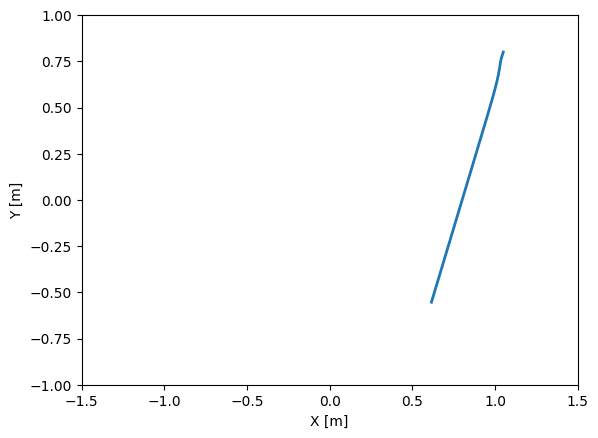

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

X_plot = np.array(X_plot)
#Task: create of plot of the trajectory
plt.plot(X_plot[:,0],X_plot[:,1],linewidth=2)  #prima e seconda componente, l'angolo non ci interessa 
plt.plot(1.05,0,8,'*',color='black')
#Drawing options
plt.ylim(-1,1)
plt.xlim(-1.5,1.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')